# Lagged cross-covariance analysis

Resolution: 5-degree, monthly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils

In [3]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("grey")

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Cut datasets to a regular grid and resample to monthly averages within each grid cell
df_sif_monthly = (
    utils.regrid(DS_sif, res=5)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_monthly = (
    utils.regrid(DS_xco2, res=5)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, on=["lon", "lat", "time"], how="outer")
df_grid_monthly

,lon,lat,time,sif,xco2
0,-177.5,-87.5,2014-11-01,0.013318,NaN
1,-177.5,-87.5,2014-12-01,-0.075980,NaN
2,-177.5,-87.5,2015-01-01,NaN,NaN
3,-177.5,-87.5,2015-02-01,NaN,NaN
4,-177.5,-87.5,2015-03-01,NaN,NaN
...,...,...,...,...,...
94276,17.5,77.5,2014-11-01,NaN,NaN
94277,17.5,77.5,2014-12-01,NaN,NaN
94278,17.5,77.5,2015-01-01,NaN,NaN
94279,17.5,77.5,2015-02-01,NaN,NaN


In [6]:
# Check coverage
df_monthly_counts = df_grid_monthly.dropna().groupby(["lon", "lat"]).count()
df_monthly_counts

time  sif  xco2
lon    lat                   
-177.5  67.5    27   27    27
        72.5     6    6     6
-172.5  62.5    24   24    24
        67.5    24   24    24
-167.5  62.5    15   15    15
...            ...  ...   ...
 177.5 -42.5    55   55    55
       -37.5    57   57    57
       -17.5    40   40    40
        62.5    31   31    31
        67.5    27   27    27

[938 rows x 3 columns]

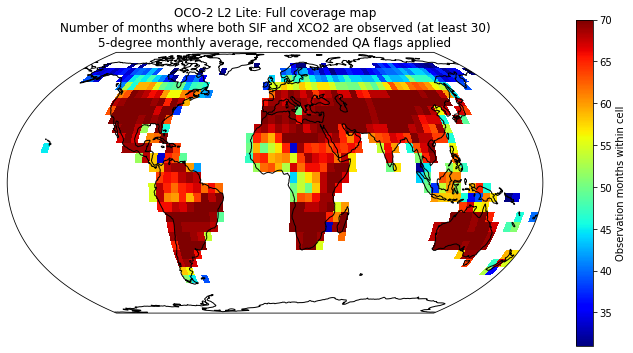

In [8]:
# Coverage map
DS_monthly_counts = df_monthly_counts.to_xarray()
da_counts = xarray.where(DS_monthly_counts.time > 30, DS_monthly_counts.time, np.nan)

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(da_counts.T, transform=ccrs.PlateCarree(),
                   cmap="jet", cbar_kwargs={"label": "Observation months within cell"}, ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Full coverage map\n" 
             "Number of months where both SIF and XCO2 are observed (at least 30)\n"
             "5-degree monthly average, reccomended QA flags applied")

plt.savefig("../plots/5degree_monthly_coverage.png")

In [9]:
# Convert to dataset
DS_grid_monthly = df_grid_monthly.set_index(["lon", "lat", "time"]).to_xarray()
DS_grid_monthly

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 72, time: 71)
Coordinates:
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 67.5 72.5 77.5 82.5
  * time     (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-07-01
Data variables:
    sif      (lon, lat, time) float32 nan nan 0.013318249 ... nan nan nan
    xco2     (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan

In [10]:
# Compute cross covariance for each grid cell
da_xcov_monthly = stats.apply_cross_covariance(DS_grid_monthly.sif, DS_grid_monthly.xco2, lag=4)

da_xcov_monthly

<xarray.DataArray (lon: 72, lat: 35)>
array([[        nan,         nan,         nan, ..., -0.01285613,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 67.5 72.5 77.5 82.5

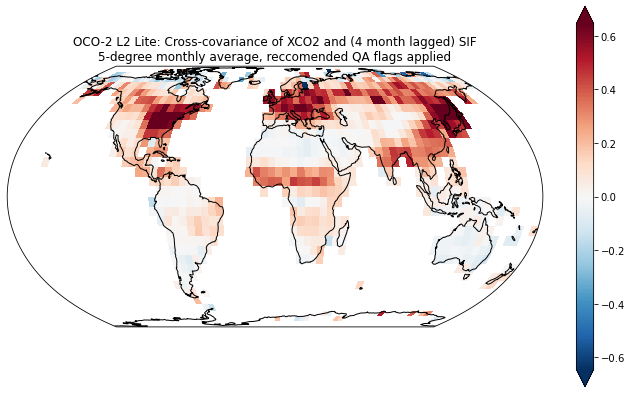

In [11]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(da_xcov_monthly.T, robust=True,
                   transform=ccrs.PlateCarree(), ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Cross-covariance of XCO2 and (4 month lagged) SIF\n" 
             "5-degree monthly average, reccomended QA flags applied")

plt.savefig("../plots/5degree_monthly_xcov.png");